# Orienteering Problem per la pianificazione di itinerari negli Scavi di Pompei

## Orienteering
Il problema dell'**Orienteering (OP)** consiste nel generare percorsi vincolati nel **tempo TMAX (o nella distanza DMAX)** attraverso un grafo, per un giocatore (nel caso di applicazione reale in esame un turista), in modo tale che lo **score** ottenuto visitando i nodi venga massimizzato. Ciascun tour di un giocatore inizia in un nodo (**start point**) diverso dal nodo di terminazione (**end point**). 

Il problema dell'Orienteering (OP), presenta diverse generalizzazioni e varianti. Nel seguente elaborato si tratta il problema **deterministico**, in cui un giocatore sceglie l'insieme di nodi da visitare in maniera tale che l'ordine di visita non ecceda l'intervallo di tempo specificato TMAX (o la distanza massima DMAX). Questo è un problema molto generale che si trova in numerose applicazioni, compreso il problema della **pianificazione di un tour turistico**.

## Lo studio del problema di un'applicazione reale dell'Orienteering Problem

<justify> 
    
Si studia il problema della generazione automatica ed efficiente di itinerari per turisti che
vogliono visitare il sito archeologico di Pompei. Fare il piano di visita che include i Point Of Interest più interessanti da visitare, per la distanza o tempo a disposizione, è solitamente un problema complesso. Pertanto si creano sistemi che tendono a soddisfare il più possibile la soddisfazione del turista realizzando un piano di viaggio personalizzato. Solitamente, i vincoli presi in considerazione dai sistemi di pianificazione in discussione sono: ubicazione geografica dei POI, i loro orari, punteggio di ciascun POI, durata del viaggio, ecc. Il problema più semplice nella pianificazione del tour può essere studiato con il problema di Orienteering (OP), dove viene fornito un numero $n$ di POI, ciascuna con un punteggio $S_i$. L’obiettivo è quello di avere un unico tour che includa il maggior numero di POI possibile, in modo da massimizzare il fattore di soddisfazione del viaggio. Si risolverà prima il problema con un metodo esatto e poi valutare le differenze attraverso le euristiche scelte.
    
</justify>

## Formulazione matematica del problema

L’obiettivo è pianificare un tour di più ore che servirà al
turista la visita di un certo numero di ambienti del sito archeoligico/POI (Point Of Inte-
rest). Viene dunque fornito un insieme di n luoghi, dove a ciascuno di essi è associato un valore di soddisfazione (score) $S_i$. Ogni tour è limitato ad
una distanza massima (Dmax), inizia in un determinato punto (*start point*) e termina in un
altro punto fisso (*end point*).
In generale, non tutte gli ambienti possono essere visitati durante la visita, poichè i km percorsi
della visita è limitato ad un certo *Dmax*. Ogni ambiente può essere visitato al massimo una volta. 
L’obiettivo è trovare una visita che includa il maggior valore di soddisfazione totale tenendo conto della distanza massima prefissata del viaggio. 

Per dimostrare che il modello funzioni, si è provato ad applicare dei Benchmark al modello esatto e alle euristiche confrontandone i risultati. Soltanto dopo, applichiamo il modello ad un'applicazione reale descritta nel problema. 

***Si è studiato una possibile proporzionalitra tra Dmax e il tempo di visita***

### Modellazione

Sulla base dei fatti sopra indicati, il problema di pianificazione può essere definito con le seguenti espressioni matematiche:

- **Variabili decisionali:**

    - $x_{ij}$ = 1 se l’arco (𝑖,𝑗) ∈ 𝐴 appartiene al percorso seguito dal concorrente, 0 altrimenti

    - $𝑦_𝑖$ = 1  se il nodo 𝑖∈𝑉 è visitato, 0 altrimenti
    
   

- **Funzione Obiettivo:**
\begin{equation}
    max \sum_{i=1}^n s_i y_i
\end{equation}


La funzione obiettivo (1) è massimizzare il valore di valutazione di soddisfazione dell’ambiente (Score).

- **Vincoli:**

\begin{equation}
    \sum_{j=2}^n x_{1j} = \sum_{i=1}^{n-1} x_{in} = 1
\end{equation}

Il vincolo (2) garantisce che il percorso inizi da uno *start point* e termina ad un *end point*.

\begin{equation}
    \sum_{i=1 \\ i \neq j}^{n} x_{ij} = \sum_{i=1 \\ i \neq j}^{n} x_{ji} \hspace{1cm} j = 2..n-1   
\end{equation}

    
Il vincolo (3) garantisce che ogni nodo ha un arco entrante e un arco uscente in modo tale che viene visitato soltanto una volta quel determinato POI.

\begin{equation}
    \sum_{i=1 \\ i \neq j}^n x_{ij} = y_j \hspace{1cm} j = 1..n
\end{equation}

Il vincolo (4) garantisce che il generico nodo j è visitato se ha un arco entrante

\begin{equation}
    \sum_{i=1}^n \sum_{j=1 \\ i \neq j}^n d_{ij} x_{ij} \leq DMax
\end{equation}

Il vincolo (5) garantisce che il percorso non può avere una distanza maggiore di **DMAX** 

Per evitare che nella soluzione calcolata ci siano dei subtour sarà allora necessario eliminarli attraverso i vincoli di assenza di subtour:

Si applicano sia i *Lazy Constraint* utilizzando i seguenti vincoli:

\begin{equation}
    \sum_{(i,j) \epsilon S}^{} x_{ij} \le |S| - 1  \hspace{1cm} S \subset V \hspace{1cm} 2 \le |S| \le |V| - 1 \label{subtour}
\end{equation}

e sia gli *MTZ* dove $u_i$ è una variabile che determina l'ordine di visita dell'$i$ esimo nodo
\begin{equation}
    u_1 = 0
\end{equation}
\begin{equation}
    0 \leq u_i \leq n-1 \hspace{1cm} intera \hspace{1cm} i=1..n
\end{equation}
\begin{equation}
    u_j - u_i \geq 1-n(1-x_{ij}) \hspace{1cm} i,j = 1..n,i \neq j,j \neq 1
\end{equation}

Si valuteranno le differenze in seguito.

**Vincoli di fisica realizzabilità**
\begin{equation}
    x_{ij}, y_{ij} \hspace{0.2 cm} \in {{0,1}} \hspace{1cm} i,j \in A
\end{equation}


## Algoritmi risolutivi

Per la risoluzione del problema ci avvaliamo dei seguenti algoritmi risolutivi utilizzando Python ed eseguendo gli script su macchine che montano un processore Intel Core i7 (11 esima generazione, quad-core) e 16 GB di RAM. (DA CORREGGERE SICURAMENTE STA PARTE INVENTATA A CASO)

### Algoritmo esatto

L'approccio seguito è mostrato nel seguente diagramma:
**OCCCHIOOOOOOOOO QUAAAA**

$\newline$
<div>
<img src="Immagini_Jupyter\modelloesattosimple.png" width="500"/>
</div>
$\newline$

#### Lettura dati dal .csv

Per il test del modello è possibile testare le seguenti istanze per il benchmark:
- Bench32 
- Bench52
- Bench102

Per il test del modello per l'applicazione reale inserire nella riga "namefile" le seguenti istante create dagli autori:
- Scavi_Archeologici_Pompei_Anfiteatro_Misteri
- Scavi_Archeologici_Pompei_Marina_Misteri
- Scavi_Archeologici_Pompei_Marina_Anfiteatro

*N.B* Le istanze dell'applicazione reale sono state scelte sulla base di differenti start_point e end_point
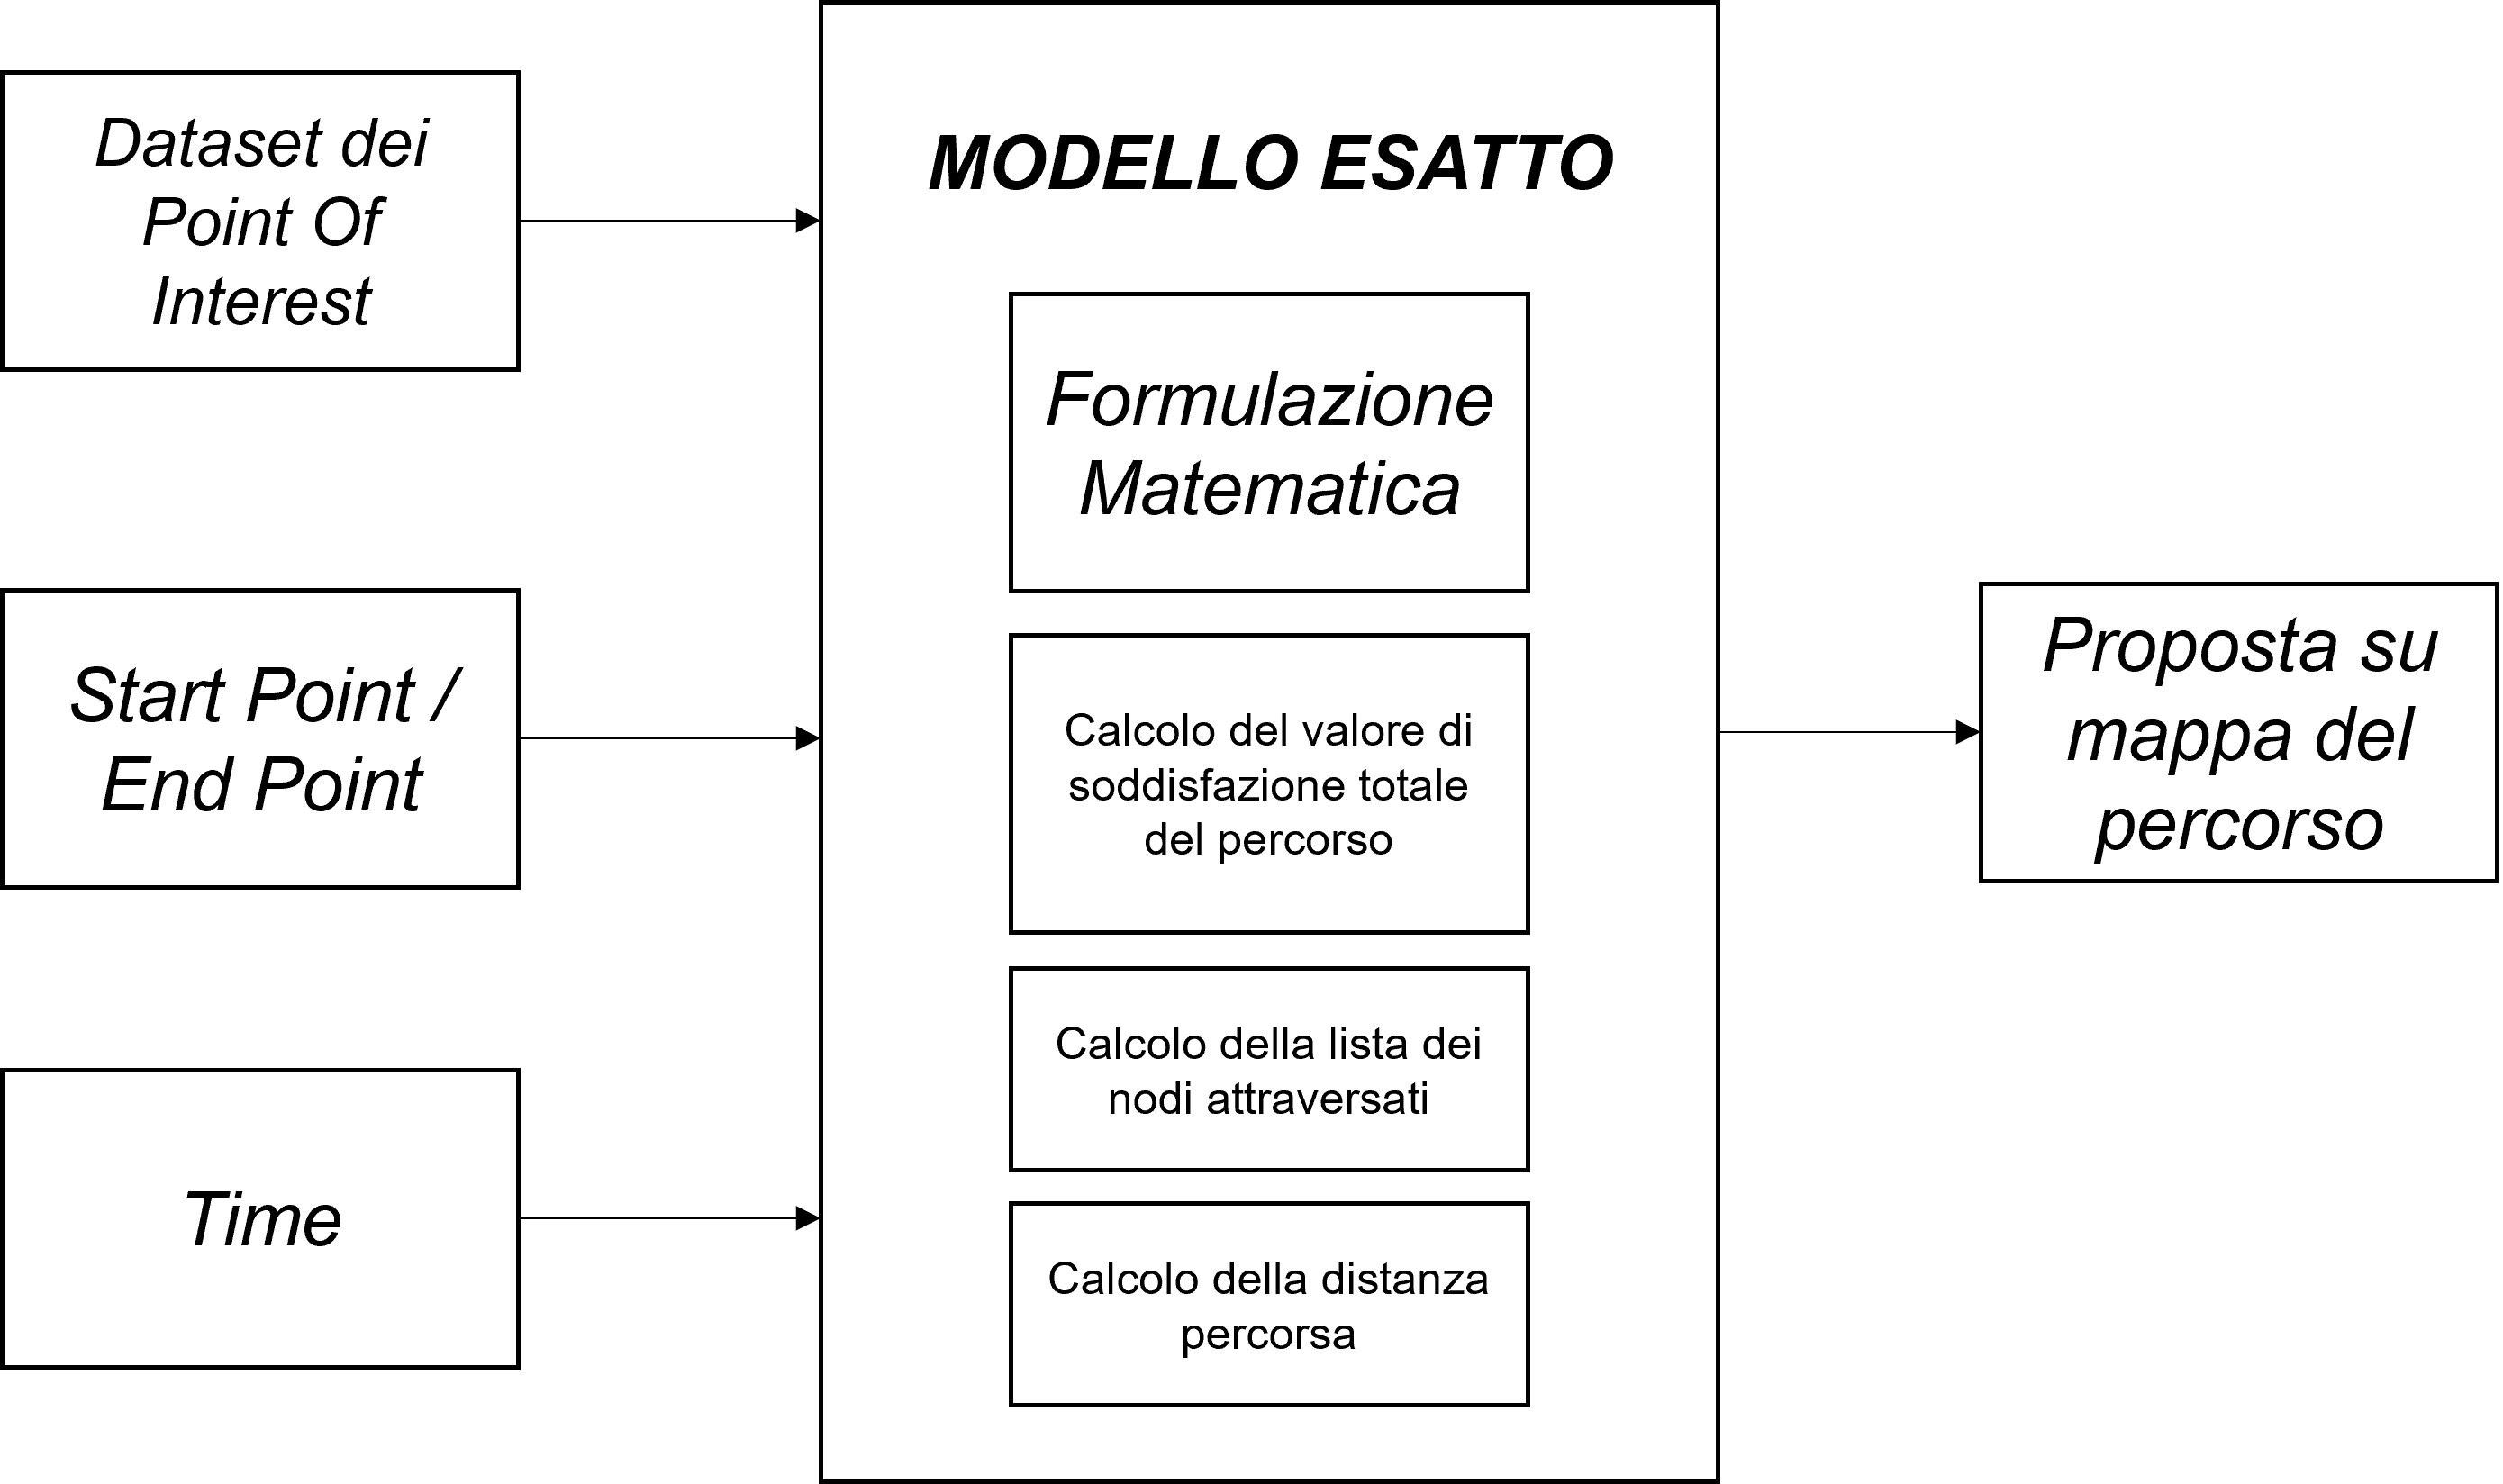

In [1]:
import pandas as pd

siti = []
coordinate = {}
score = {}

#Parametri del problema

#Si scelga il metodo per l'eliminazione dei subtour:
MTZ=0 #se è 1 uso gli MTZ, altrimenti uso i lazy constraints

#Si scelga il DMAX
"""
    Per il test dei Benchmark usare i seguenti DMAX: 20,50,70
    Per il test dell'applicazione reale usare i seguenti DMAX: 0.02,0.03,0.04
    Tale differenza dei DMAX è dovuta dalla differenza delle distanze valutate tra i vari nodi
    
"""
DMAX=0.04

#Si inserisca l'istanza indicata nel riquadro superiore
namefile = "Scavi_Archeologici_Pompei_Anfiteatro_Misteri"
with open('./IstanzeBenchmark/' + namefile + '.txt') as file:
    for i, line in enumerate(file):
            node = line.split(',')
            if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
                namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
                namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro" ):
                sito = str(node[0])
                siti.append(sito)
                coordinate[sito] = (float(node[2]),float(node[1]))
                score[sito] = int(node[3])
                zoom = 16
                raggio = 900
            else:
                sito = str(i)
                siti.append(sito)
                coordinate[sito] = (float(node[1]),float(node[0]))
                score[sito] = int(node[2])
                zoom = 5
                raggio = 5000000

#### Calcolo distanza tra due POI
Per la valutazione delle distanze tra i POI si è utilizzata la metrica Euclidea: <br>
Siano due punti $P_i$ e $P_j$ allora:
\begin{equation}
    d(P_i, P_j) = [(x_i - x_j)^2 + (y_i - y_j)^2]^{(\frac{1}{2})}
\end{equation}

*N.B* **che significa LDA?**

In [2]:
import math

def distance(sito1, sito2):
    c1 = coordinate[sito1]
    c2 = coordinate[sito2]
    
    #Metrica di Euclide per la valutazione della distanza tra due punti
    diff = (c1[0]-c2[0], c1[1]-c2[1])
    return (math.sqrt(diff[0]*diff[0]+diff[1]*diff[1]))

dist = {(c1, c2): distance(c1, c2) for c1 in siti for c2 in siti if c1 != c2 }

#### Calcolo del punto medio tra quelli dati per rappresentarli sulla mappa

Utile per la visualizzazione ottimale della mappa

In [3]:
media_lat=0
media_long=0

for sito in siti:
    media_lat = media_lat + coordinate[sito][0]
    media_long = media_long + coordinate[sito][1]
    
lat=media_lat/len(coordinate)
long=media_long/len(coordinate)

#### I nodi del problema

**DA VEDERE**


In [4]:
#Marker sulla mappa: I nodi del problema
import folium
map = folium.Map(location=[lat,long], zoom_start = zoom)
for sito in siti:
    folium.Marker(location = coordinate[sito], tooltip = sito, icon=folium.Icon(color='darkred')).add_to(map)

# add search area circle
folium.Circle(radius=raggio, location=[lat,long], color='darkred').add_to(map)

map

#### Modellazione Gurobi per il modello esatto
Si inizializza il problema e si definiscono le variabili di decisione $x_{ij}$ e $y_i$
**OCCHIO**

In [5]:
#MODELLAZIONE GUROBI
import numpy as np
import gurobipy as gp
from gurobipy import GRB

if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
    namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
    namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro" ):
    model = gp.Model('Pompei_orienteering') #definizione del modello
else:
    model = gp.Model(str(namefile) + '_orienteering') #definizione del modello

#Definizione variabili di decisione
Xvars = model.addVars(dist.keys(), obj = dist, vtype = GRB.BINARY, name = 'x') #xij OCCHIO QUI - dist.keys e objdst sono giust?
Yvars = model.addVars(siti, obj = 0.0, vtype = GRB.BINARY, name = 'y')  #yi

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-07-10


#### Funzione obiettivo

\begin{equation}
    max \sum_{i=1}^n s_i y_i
\end{equation}

In [6]:
#Definizione della funzione obiettivo
obj = model.setObjective(gp.quicksum(Yvars[i]*score[i] for i in siti), gp.GRB.MAXIMIZE)

#### Vincoli Hamiltoniani

\begin{equation}
    \sum_{j=2}^n x_{1j} = \sum_{i=1}^{n-1} x_{in} = 1
\end{equation}

In [7]:
start_point = siti[0]
#Dal nodo di partenza (si indichi quale) esce soltanto un nodo
OutFirst = model.addConstr(Xvars.sum(start_point,'*') == 1) 

In [8]:
end_point = siti[len(siti)-1]
#Dal nodo di uscita (si indichi quale) esce soltanto un nodo
InLast = model.addConstr(Xvars.sum('*',end_point) == 1)

\begin{equation}
    \sum_{i=1 \\ i \neq j}^{n-1} x_{ij} = \sum_{i=2 \\ i \neq j}^{n} x_{ji} \hspace{1cm} j = 2..n-1   
\end{equation}

In [9]:
#Vincolo di bilancio degli archi sui nodi intermedi
Balance = model.addConstrs((gp.quicksum(Xvars.sum(i,j) for i in siti if i != end_point) 
                            == gp.quicksum(Xvars.sum(j,i) for i in siti if i != start_point)
                            for j in siti if i != j and j != start_point and j != end_point))

\begin{equation}
    \sum_{i=2 \\ i \neq j}^n x_{ji} = y_j \hspace{1cm} j = 1..n-1
\end{equation}

In [10]:
#Vincolo di visita
Visited = model.addConstrs((gp.quicksum(Xvars.sum(j,i) for i in siti if i != start_point) == Yvars[j]
                            for j in siti if i != j and j != end_point))

\begin{equation}
    \sum_{i=1}^n \sum_{j=1 \\ i \neq j}^n d_{ij} x_{ij} \leq DMax
\end{equation}

In [11]:
#Vincolo sul DMAX (si indica il tempo di visita)
MaxDistanza = model.addConstr((gp.quicksum(Xvars[i,j]*dist[i,j] for i in siti for j in siti if i != j) <= DMAX))

#### Vincoli di subtour MTZ
Per una implementazione più semplice si è deciso di valutare gli MTZ nel seguente modo: <br>
Se $x_{i,j} = 1$ allora 
      \begin{equation}
      u_i + 1 = u_j \hspace{1cm} i,j = 1..n,i \neq j,j \neq 1
      \end{equation}

In [12]:
#Vincoli di sottogiro MTZ
if MTZ == 1:
    #definizione della variabile u
    Uvars = model.addVars(siti, vtype = GRB.CONTINUOUS, name = 'u')
    
    #Se Xij = 1 allora uj = ui + 1 (SE E SOLTANTO SE >>)
    Posizione = model.addConstrs((Xvars[i,j] == 1) >> (Uvars[i]+1==Uvars[j]) for i in siti for j in siti 
                                 if j != start_point and i != j)

In alternativa ai vincoli di sottogiro MTZ, si possono aggiungere i **Lazy Constraints** (modificando opportunamente quelli offerti da GUROBI)

\begin{equation}
    \sum_{(i,j) \epsilon S}^{} x_{ij} \le |S| - 1  \hspace{1cm} S \subset V \hspace{1cm} 2 \le |S| \le |V| - 1 \label{subtour}
\end{equation}

**AGGIUNGERE SPIEGAZIONE DETTAGLIATA IN QUANTO POTENZIALE DOMANDA A TRABOCCHETTO**

In [13]:
#Funzioni per eliminare i subtour (Callback)
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        # preleva la soluzione corrente
        Xvals = model.cbGetSolution(model._Xvars)
        selected = gp.tuplelist((i,j) for i, j in model._Xvars.keys() if Xvals[i,j] > 0.5)
        # cerca il ciclo di lunghezza minima nella soluzione
        tour = subtour(selected)

def subtour(edges):
    unvisited = list(siti)
    while unvisited:
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                            if j in unvisited]
        #aggiunto vincolo come nella formulazione
        if len(thiscycle) >= 2 and len(thiscycle) <= len(siti)-1: 
            model.cbLazy(gp.quicksum(model._Xvars[i,j] for i in thiscycle for j in thiscycle if i != j )
                         <= len(thiscycle)-1)

#### Scrittura del modello completo su .lp ed esecuzione del solutore

In [14]:
if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
    namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
    namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro" ):
    model.write(str(namefile) + '_orienteering.lp')
else:
    model.write(str(namefile) + '_orienteering.lp')

Se l'esecuzione del solutore impiega molto tempo (al max 120s) rimuovere il commento: <br>
*#model.Params.MIPGap = 0.30* e scegliere la percentuale di MIPGap di Gurobi (in questo caso del 30%)

Gurobi infatti "misura" l'ottimalità della soluzione attraverso il rapporto tra:

\begin{equation}
MIPGap = \frac{|best_{objective} - best_{bound}|}{best_{objective}}
\end{equation}

Se non gli viene fornita una percentuale, Gurobi continuerà ad eseguire fino a quando il MIPGap non raggiungerà lo 0.00% e purtroppo essendo che le dimensioni del problema sono rilevanti impiegherà molto tempo per valutare l'ottima soluzione.


In [15]:
import time
start = time.time() #Start-Esecuzione

if MTZ == 1:
    #model.Params.MIPGap = 0.10 #**50 *30 ***10 
    model.optimize()
else:
    model._Xvars = Xvars
    model.Params.lazyConstraints = 1
    model.optimize(subtourelim)
    
end = time.time()
time_exec = round(end - start,3)
print('Tempo di esecuzione ' + str(time_exec))

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 86 rows, 1849 columns and 7017 nonzeros
Model fingerprint: 0xfe812bb2
Variable types: 0 continuous, 1849 integer (1849 binary)
Coefficient statistics:
  Matrix range     [3e-04, 1e+00]
  Objective range  [2e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 1e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.02s
Presolved: 85 rows, 1848 columns, 5328 nonzeros
Variable types: 0 continuous, 1848 integer (1848 binary)
Found heuristic solution: objective 3.0000000

Root relaxation: objective 1.340000e+02, 315 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  134.00000    0    6    3.00000  134.00000  4367%     -

#### Stampa dei risultati 
Il risultato indica il percorso da seguire:

In [16]:
#Funzione per costruire il percorso a partire dalla soluzione
def createtour(solution):
    unvisited = list(siti)
    neighbors = unvisited
    tour = []
    while neighbors:
            current = neighbors[0]
            tour.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in solution.select(current, '*')
                            if j in unvisited]
    return tour

In [17]:
#Stampa dei risultati
if model.status == GRB.OPTIMAL:

    foundOptimalSol = True
    Xvals = model.getAttr('x', Xvars)
    #ottengo la soluzione
    solution = gp.tuplelist((i,j) for i,j in Xvals.keys() if Xvals[i,j] > 0.5)
    #prelevo il punteggio
    punteggio = model.ObjVal
    
    #Stampa del percorso ricavato con le MTZ
    if MTZ == 1:
        Uvals = model.getAttr('x', Uvars)
        
        optTour=createtour(solution)
        percorso=list(optTour)
        
        print('Valore di soddisfazione TOTALE - MTZ: %g' % punteggio)
    
    #Stampa del percorso ricavato con i Lazy Constraints
    else:
        optTour=createtour(solution)
        percorso=list(optTour)

        punteggio=0
        for i in percorso:
            punteggio+=score[i]
        
        print('Valore di soddisfazione TOTALE - LAZY: %g' % punteggio)
    
    #Stampa del numero dei Point of Interests
    print("N.POI: %g" % len(percorso))
    
    #Stampa della distanza totale
    lunghezza=0
    for i in solution:
        lunghezza+=dist[i]
    print('Distanza percorsa in km (lda): ' + str(lunghezza))
    
    #Stampa del percorso
    print(percorso)

Valore di soddisfazione TOTALE - LAZY: 130
N.POI: 41
Distanza percorsa in km (lda): 0.03980092578996593
['Piazza Anfiteatro', 'Palestra Grande', 'Anfiteatro di Pompei', 'Casa del Foro Boario', 'Villa di Giulia Felice', 'Casa di Ottavio Quartione', 'Casa del Moralista', "Casa del Triclinio all'aperto", 'Casa della Nave Europa', 'Casa e Thermopolium di Vetutius Placidus', "Casa dell'Efebo", 'Casa del Criptoportico', 'Casa dei Ceii', 'Casa del Menandro', 'Tempio di Iside', 'Teatro Grande', 'Foro Triangolare', 'Terme Stabiane', 'Lupanare di Pompei', "Casa dell'Orso Ferito", 'Casa di Orione', "Casa delle Nozze d'Argento", 'Casa di Leda e il Cigno', 'Casa degli Amorini Dorati', 'Casa dei Vettii', 'Casa del Fauno', 'Tempio della Fortuna Augusta', 'Terme del Foro', 'Granai del Foro', 'Foro di Pompei', 'Santuario di Apollo', 'Basilica Pompeiana', 'Tempio di Venere', 'Antiquarium di Pompei', 'Casa del Poeta Tragico', 'Casa dei Dioscuri', 'Casa di Apollo', 'Casa del Chirurgo', 'Necropoli di Porta

#### Stampa del tour in linea d'aria

In [18]:
# Stampa del tour degli scavi di Pompei in linea d'aria 
import folium
import folium.plugins as plugins
map = folium.Map(location=[lat,long], zoom_start = zoom)

points = []
for sito in percorso:
    points.append(coordinate[sito])
    if sito == start_point: #start point 
            folium.Marker(location = coordinate[sito], tooltip = sito, 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    border_color= '#b22222',
                                                    background_color='#b22222')).add_to(map)
    elif sito == end_point: #end point
            folium.Marker(location = coordinate[sito], tooltip = sito, 
                          icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                    border_color= '#ffd700',
                                                    background_color='#ffd700')).add_to(map)
    else:
            folium.Marker(location = coordinate[sito], tooltip = sito, icon=folium.Icon(color='darkred')).add_to(map)
    


folium.PolyLine(points, color='darkred').add_to(map)

map

In [19]:
conv_coord = []
mytour=[]
i=0
for sito in percorso:
    conv_coord.append((coordinate[sito][1],coordinate[sito][0]))
    mytour.append(list(conv_coord[i]))
    i+=1

#### Stampa del percorso a piedi per l'applicazione reale (Scavi di Pompei)

In [20]:
#Stampa del percorso per vie REALI 
#(ovviamente la distanza in km sarà leggermente diversa da quella in linea d'aria)
if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
    namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
    namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro" ):    
        import openrouteservice as ors
        import folium
        import folium.plugins as plugins

        # API Key di Open Route Service
        ors_key = '5b3ce3597851110001cf6248435cfcfbcf0c42858fde19dccf6f9c0f'

        # Richiesta dei servizi tramite API Key di ORS
        # Apro un Client per effettuare le richieste al Server di ORS
        client = ors.Client(key=ors_key)

        # Traccio il percorso
        route = client.directions(coordinates=mytour,
                                  profile='foot-walking',
                                  format='geojson')


        map = folium.Map(location=[lat,long], zoom_start = zoom)
        #for sito in percorso:
            #folium.Marker(location = coordinate[sito], tooltip = sito).add_to(map)

        num = 0
        for sito in percorso:
            if sito == start_point: #start point 
                folium.Marker(location = coordinate[sito], tooltip = sito, 
                              icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                        number=num,
                                                        border_color= '#b22222',
                                                        background_color='#b22222')).add_to(map)
            elif sito == end_point: #end point
                folium.Marker(location = coordinate[sito], tooltip = sito, 
                              icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                        number=num,
                                                        border_color= '#ffd700',
                                                        background_color='#ffd700')).add_to(map)
            else:
                folium.Marker(location = coordinate[sito], tooltip = sito, 
                              icon=plugins.BeautifyIcon(icon="arrow-down", icon_shape="marker",
                                                        number=num,
                                                        border_color= '#b22222',
                                                        background_color='#ffffff')).add_to(map)
            num+=1

        # Aggiungo il GeoJson alla mappa
        folium.GeoJson(route, name=('Itinerario Scavi di Pompei con ' + str(DMAX) + ' ore'), 
                       style_function=lambda feature: {'color': 'darkred'}).add_to(map)

        # Aggiungo il livello del percorso alla mappa
        folium.LayerControl().add_to(map)

        print('Distanza percorsa in km (reale): ' + str((route['features'][0]['properties']['summary']['distance'])/1000))

map

Distanza percorsa in km (reale): 6.3624


In [21]:
if (namefile == "Scavi_Archeologici_Pompei_Anfiteatro_Misteri" or 
    namefile == "Scavi_Archeologici_Pompei_Marina_Misteri" or
    namefile == "Scavi_Archeologici_Pompei_Marina_Anfiteatro" ):
    model.write(str(namefile) + '_orienteering_sol.lp')
else:
    model.write(str(namefile) + '_orienteering_sol.lp')

#### Salvataggio dei risultati

In [22]:
import csv

colonne = ['Istanza','DMAX','Metodo','N.POI','Lunghezza percorso (km)','Valore di soddisfazione (TOTALE)','Tempo di esecuzione (s)']
with open('./Confronti.csv', mode='a', newline='') as csv_file:
    
    writer = csv.DictWriter(csv_file, fieldnames=colonne)

    if MTZ==1:
        writer.writerow({'Istanza': namefile,'DMAX': DMAX,'Metodo': 'OPT MTZ','N.POI': len(percorso),'Lunghezza percorso (km)': round(lunghezza,5),'Valore di soddisfazione (TOTALE)': punteggio, 'Tempo di esecuzione (s)': time_exec})
    else:
        writer.writerow({'Istanza': namefile,'DMAX': DMAX,'Metodo': 'OPT L.C.','N.POI': len(percorso),'Lunghezza percorso (km)': round(lunghezza,5),'Valore di soddisfazione (TOTALE)': punteggio, 'Tempo di esecuzione (s)': time_exec})
        